<a href="https://colab.research.google.com/github/naoto-git/for_submit/blob/main/bert_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-models-official==2.3.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [2]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [3]:
glue, info = tfds.load('glue/mrpc', with_info=True, batch_size=-1)

In [35]:
list(glue.keys())

['test', 'train', 'validation']

In [36]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [37]:
info.features["label"].names

['not_equivalent', 'equivalent']

In [4]:
glue_train = glue["train"]
for key, value in glue_train.items():
  print(f"{key:9s}:{value[0].numpy()}")

idx      :1680
label    :0
sentence1:b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2:b'The rovers act as robotic geologists , moving on six wheels .'


In [12]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True
)
print("Vocab size: ", len(tokenizer.vocab))

Vocab size:  30522


In [13]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [14]:
tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]"])

[101, 102]

In [8]:
def encode_sentence(s):
  tokens = list(tokenizer.tokenize(s.numpy()))
  tokens.append("[SEP]")
  return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
        encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
        encode_sentence(s) for s in glue_train["sentence2"]])

print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


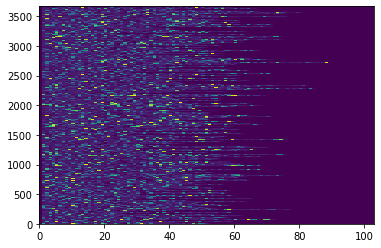

In [23]:
cls = [tokenizer.convert_tokens_to_ids(["[CLS]"])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

In [44]:
input_word_ids[1]

<tf.Tensor: shape=(59,), dtype=int32, numpy=
array([  101,  2625,  2084,  2322,  3867,  1997, 23193,  1005,  1055,
        4341,  2052,  2272,  2013,  2437, 13891,  1998,  3259,  2044,
        1996,  2436, 17848,  5309,  2003,  2949,  1012,   102,  2625,
        2084,  2322,  3867,  1997, 23193,  1005,  1055,  4341,  2052,
        2272,  2013,  2437, 13891,  1998,  3259,  2044,  1996,  2436,
       17848,  5309,  2003,  3143,  1010, 10262,  2216,  5661,  4995,
        1005,  1056,  2853,  1012,   102], dtype=int32)>

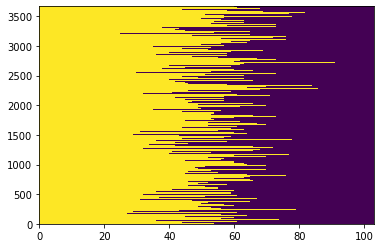

In [24]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

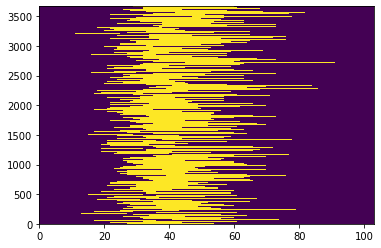

In [25]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
plt.pcolormesh(input_type_ids)

In [27]:
print(input_word_ids[0], input_type_ids[0])
print(len(input_word_ids[0]), len(input_type_ids[0]))

tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102], shape=(33,), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(103,), dtype=int32)
33 103


以上をまとめた関数

In [15]:
def encode_sentence(s, tokenizer):
  tokens = list(tokenizer.tokenize(s))
  tokens.append("[SEP]")
  return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  sentence1 = tf.ragged.constant(
      [encode_sentence(s, tokenizer) for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant(
      [encode_sentence(s, tokenizer) for s in np.array(glue_dict["sentence2"])])
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.zeros_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      "input_word_ids" : input_word_ids.to_tensor(),
      "input_mask" : input_mask,
      "input_type_ids" : input_type_ids
  }
  return inputs

In [16]:
glue_train = bert_encode(glue["train"], tokenizer)
glue_train_labels = glue["train"]["label"]

glue_validation = bert_encode(glue["validation"], tokenizer)
glue_validation_labels = glue["validation"]["label"]

glue_test = bert_encode(glue["test"], tokenizer)
glue_test_labels = glue["test"]["label"]

for key, value in glue_train.items():
  print(f"{key:15s} shape: {value.shape}")
print(f"glue_train_labels shape:{glue_train_labels.shape}")

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape:(3668,)


bert のダウンロード

In [49]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

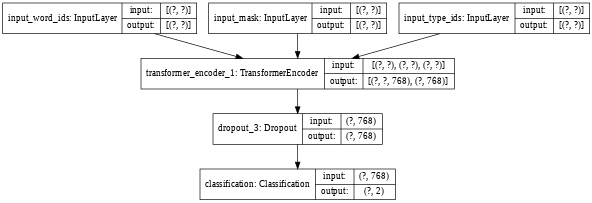

In [50]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2
)
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [51]:
glue_batch = {key: val[:10]for key, val in glue_train.items()}
bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.009188  , -0.22315761],
       [ 0.0848238 , -0.17304292],
       [-0.04085093, -0.35166505],
       [ 0.00457677, -0.22806357],
       [ 0.01525783, -0.13459206],
       [-0.05330314, -0.26922205],
       [-0.03763685, -0.09934592],
       [ 0.15113427,  0.04671613],
       [ 0.22380084,  0.1494165 ],
       [ 0.0852854 , -0.12431265]], dtype=float32)

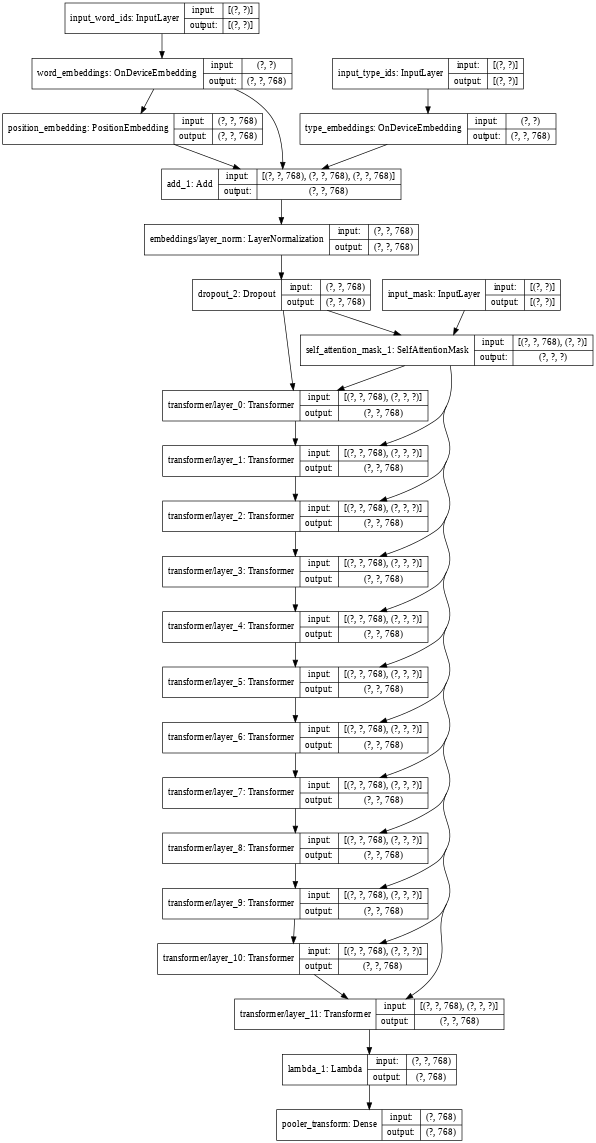

In [52]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [53]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(os.path.join(gs_folder_bert, "bert_model.ckpt")).assert_consumed()

In [54]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size/batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1/ batch_size)

optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, 
                                              num_warmup_steps=warmup_steps)

In [55]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(
    "accuracy", dtype=tf.float32
)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer, loss=loss, metrics=metrics
)

bert_classifier.fit(
    glue_train, glue_train_labels,
    validation_data=(glue_validation, glue_validation_labels),
    batch_size=32, epochs=epochs
)

Epoch 1/3


In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)
result = bert_classifier(my_examples, training=False)
result = tf.argmax(result).numpy()
result

In [ ]:
np.array(info.features['label'].names)[result]

In [ ]:
export_dir="./saved_model"
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

In [10]:
import tensorflow_hub as hub

hub_model_name = "bert_en_uncased_L-12_H-768_A-12" 
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/{hub_model_name}/2", trainable=True)
print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


In [ ]:
result = hub_encoder(
    inputs = [glue_train['input_word_ids'][:10],
              glue_train["input_mask"][:10],
              glue_train["input_type_ids"][:10],],
              training=False,
)
print("Pooled output shape:", result[0].shape)
print("Sequence output shape:", result[1].shape)

In [19]:
import json

gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

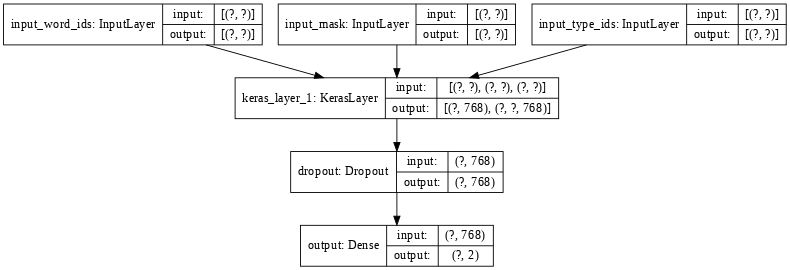

In [20]:
hub_classifier, hub_encoder = bert.bert_models.classifier_model(
    bert_config=bert_config, hub_module_url=hub_url_bert, num_labels=2
)
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [21]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'
